## Extreme Gradient Boosting Model
This notebook includes all relevant code regarding the implementation of XGB for short term load forecasting as part of the EG2140 project course.

Authors: Florian Kühn, (Andreas Liv, Ali Kamran)

In [2]:
#pip install -r requirements_XGB.txt

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, holidays
import xgboost as xgb
import joblib
from xgboost import XGBRegressor
from darts import TimeSeries
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from scipy.stats import randint, uniform
from darts.metrics import mape, rmse, mae

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 22})

: 

: 

: 

The following two functions are used to evaluate the forecasted values with respect to actual measurements. For greater clarity, the code was structured into separate functions.

In [ ]:
def print_evaluation_metrics(actual,predicted):
    '''
    Evaluation function printing out the following error metrics:
     - Mean Absolute Percentage Error (MAPE): mainly used for classification of model accuracy
     - Mean Absolute Error (MAE): used for getting a physical interpretation of what the obtained error means (MW deviation)
     - Root Mean Squared Error (RMSE): used to measure how forecasts predict outliers: higher values mean worse outlier prediction
     - Days with maximum and minimum MAPE in the considered test range
     
     actual: measured load series
     predicted: forecasted load series
     
     Darts error metrics functions were preferred over scikit-learn, as they handle extreme values better.
    '''
    # time series conversion to use Darts error metrics
    actual_series = TimeSeries.from_series(actual)
    predicted_series = TimeSeries.from_series(predicted)
    
    mape_val = mape(actual_series, predicted_series)
    rmse_val = rmse(actual_series, predicted_series)
    mae_val = mae(actual_series, predicted_series)

    print(f"MAPE: {mape_val:.2f}%")
    print(f"RMSE: {rmse_val:.2f}")
    print(f"MAE: {mae_val:.2f}MW")
    
    # Min/Max MAPE calculation
     
    df = pd.DataFrame({
        'actual': actual,
        'predicted': predicted
    })
    df.index = pd.to_datetime(df.index) 

    df = df[df['actual'] != 0] # filter out zero-values to avoid division by 0

    df['date'] = df.index.date

    df['abs_pct_error'] = np.abs(df['actual'] - df['predicted']) / df['actual'] # manual MAPE calculation according to Darts definition

    daily_mape = df.groupby('date')['abs_pct_error'].mean() * 100 # convert to %

    max_mape_value = daily_mape.max()
    min_mape_value = daily_mape.min()
    max_mape_date = daily_mape.idxmax()
    min_mape_date = daily_mape.idxmin()

    print(f"Maximum MAPE: {max_mape_value:.2f}% on {max_mape_date}")
    print(f"Minimum MAPE: {min_mape_value:.2f}% on {min_mape_date}")
    
    # boxplot of MAPE distribution
    plt.figure(figsize=(10, 5))
    plt.boxplot(daily_mape.values, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='gray'),
                capprops=dict(color='gray'),
                flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, linestyle='none'))

    plt.ylabel("MAPE (%)")
    plt.title("Distribution of Daily MAPE")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
def plot_forecast(actual, predicted, model, model_name=None, xgb_feat=False):
    '''
    Plot function printing the "actual" measured and "predicted" load sets using a given "model".
    If "model_name" is given, saves the plot to a pdf file with that string as name.
    If "xgb_feat" is given, prints XGBs feature importance plot
    
    actual: measured load series
    predicted: forecasted load series
    model: forecasting model
    model_name: optional string to name model if it should be saved
    xgb_feat: boolean, feature importance plot is printed if 'True'
    '''
    start_date = actual.index[0].strftime('%Y-%m-%d')
    end_date = actual.index[-1].strftime('%Y-%m-%d')
    
    plt.figure(figsize=(12, 6))
    actual.plot(label='Actual', lw=1)
    predicted.plot(label='Forecast', lw=1)
    plt.legend()
    plt.title('Load Forecast ({} to {})'.format(start_date,end_date))
    plt.xlabel('Date')
    plt.ylabel('Load (MW)')
    plt.grid(True)
    plt.tight_layout()
    if model_name:
        plt.savefig(model_name, format="pdf", bbox_inches="tight")
    plt.show()

    # Feature Importance Plot
    if xgb_feat:
        xgb.plot_importance(model, height=0.6, max_num_features=50)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()

: 

: 

: 

: 

Now the load data which was aggregated from several ENTSO-E measurement files is read into a pandas Dataframe named "data". 

In [ ]:
def read_load_data():
    '''
    Reads load data from file 'processed_loadUTC_data.csv'. 
    Renames columns for better handling in future code.
    '''
    
    base_dir = os.getcwd()
    load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
    load_data = pd.read_csv(load_file_path)
    load_data.rename(columns={
        "Actual Total Load [MW] - BZN|SE4": "Actual Load",
        "Time (UTC)": "Time"
    }, inplace=True)
    load_data['Time'] = pd.to_datetime(load_data['Time'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
    load_data.set_index('Time', inplace=True)
    load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
    return load_data

data = read_load_data()

: 

: 

: 

: 

Now, covariates are defined and added to the dataframe. First weather data is imported from preprocessing files in "import_weather_data()", then Swedish holidays are added in "import_swedish_holidays()". Then, datetime features are added in "create_date_features()". These three functions include the base set of covariates used in this study.

In [ ]:
def import_weather_data(df, solar_power=False):
    '''
    The weighted averages of weather data (incl. temperature, humidity and solar irradiation) is read and added to the main dataframe.
    If "solar_power" is given as 'True', solar irradiation data is replaced by an estimate of total solar power generation.
    
    df: pandas DataFrame
    solar_power: boolean for converting solar irradiation to solar power if 'True'
    '''
    # Read and store weather data into dataframe
    base_dir = os.getcwd()
    temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
    humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
    solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
    avg_temperature_data = pd.read_csv(temperature_file_path)
    avg_humidity_data = pd.read_csv(humidity_file_path)
    avg_solar_data = pd.read_csv(solar_file_path)
    df['Temperature'] = avg_temperature_data['weighted_avg'].values
    df['Humidity'] = avg_humidity_data['weighted_avg'].values
    df['Solar_Irrad'] = avg_solar_data['weighted_avg'].values
    
    # convert solar irradiation to solar power if needed
    if solar_power:
        tot_installed_capacity = np.array([2.52, 5.04, 7.56, 10.08, 12.6, 18.6, 29.2, 41.53, 69.55, 85])*1e6
        installed_capacity_house = 10*1e3
        n_installations = tot_installed_capacity / installed_capacity_house
        panel_per_house = 24
        area_per_panel = 2

        years = np.arange(2015, 2025)
        total_area_panels = n_installations * panel_per_house * area_per_panel
        area_by_year = dict(zip(years, total_area_panels))

        panel_efficiency = 0.2
        df['year'] = df.index.year
        df['Solar'] = df['Solar_Irrad'] * data['year'].map(area_by_year) * panel_efficiency
        df.drop(columns='year', inplace=True)
    else:
        df['Solar'] = df['Solar_Irrad']
    df.drop(columns='Solar_Irrad',inplace=True) # solar irradiation was either replaced by solar power or stored into column "Solar"
    return df

data = import_weather_data(data, solar_power=True)

: 

: 

: 

: 

Initially, pythons 'holidays' package included sundays as holidays. However, since these days are also part of the week-structure, they are excluded from the 'is_holiday' column to avoid ambiguity.

In [ ]:
def import_swedish_holidays(df):
    '''
    Imports Swedish holidays into column 'is_holiday' of given dataframe, excluding sundays from the holiday set.
    
    df: pandas Dataframe
    '''
    
    years = np.arange(2015, 2025)
    raw_holidays = []
    for date, name in sorted(holidays.Sweden(years=years).items()):
        #if not name == "Söndag":
        #    raw_holidays.append(date)
        raw_holidays.append(date)
    holiday_dates = set(raw_holidays)
    df['is_holiday'] = pd.Series(df.index.date).isin(holiday_dates).astype(int).values
    return df

data = import_swedish_holidays(data)

: 

: 

: 

: 

In [ ]:
def create_date_features(df):
    '''
    Creates date features marking the hour of the day, day of the week and a boolean with value 'True' if a day is part of the weekend and 'False' otherwise.
    
    df: pandas DataFrame
    '''
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    return df

data = create_date_features(data)

: 

: 

: 

: 

In [ ]:
def add_noise_to_covariates(df, noise_level: float = 0.05, random_seed=None):
    '''
    Adds Gaussian noise with set "noise_level" to weather data. Default noise standard deviation is 5%.
    
    df: pandas DataFrame
    noise_level: standard deviation for Gaussian random distribution (default is 0.05)
    random_seed: fixes random distributions for reproducibility of results
    ''' 
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # weather covariates 
    stochastic_cols = ["Temperature", "Humidity",  "Solar"]
    df_noisy = df.copy()

    for col in stochastic_cols:
        if col in df_noisy.columns:
            if col == "Solar":
                # Proportional noise based on value (avoid large noise when value is 0)
                base = df_noisy[col].values
                noise = np.random.normal(0, noise_level * base)
                df_noisy[col] += noise
                df_noisy[col] = df_noisy[col].clip(lower=0)  # Prevent negative solar
            else:
                # Standard deviation-based noise
                std = df_noisy[col].std()
                noise = np.random.normal(0, noise_level * std, size=len(df_noisy))
                df_noisy[col] += noise

    return df_noisy

future_data = add_noise_to_covariates(data, random_seed=42)

: 

: 

: 

: 

In [ ]:
def create_lag_features(df, nan=False):
    '''
    Creates lagged covariate and load features. Can fill target value (load) lags with NaNs if nan is 'True'.
    
    df: pandas DataFrame
    nan: fills all load lags with NaNs if 'True'
    '''
    
    df = df.copy()
    load="Actual Load"
    for lag in [1, 2, 3, 6, 12, 24]: 
        df[f'lag_temp_{lag}'] = df["Temperature"].shift(lag) #temperature lags: 1,2,3,6,12 and 24
        df[f'lag_humid_{lag}'] = df["Humidity"].shift(lag) #humidity lags: 1,2,3,6,12 and 24
        df[f'lag_solar_{lag}'] = df["Solar"].shift(lag) #solar lags: 1,2,3,6,12 and 24
        if lag <=3:
            df[f'lag_hour_{lag}'] = df["hour"].shift(lag) # hour of day lags: 1,2,3
        if nan:
            df[f'lag_{lag}'] = np.nan
        else:
            df[f'lag_{lag}'] = df[load].shift(lag)

    for day in range(2, 8):  
        lag = day * 24
        if nan:
            df[f'lag_{lag}'] = np.nan
        else:
            df[f'lag_{lag}'] = df[load].shift(lag)
    

    return df

data = create_lag_features(data)
data = data.dropna() # first week in 2015 dropped to enable lag features
future_data = create_lag_features(future_data, nan=True) # with NaNs as load lags to be filled later
future_data = future_data[future_data.index >= data.index.min()] # 'drop' first week as in data

: 

: 

: 

: 

In [ ]:
# Time-based train/test split
split_dates = ['2015-01-01','2024-01-01','2024-01-08', '2024-07-01', '2024-07-08', '2024-12-31']
train = data[(data.index>=split_dates[0])&(data.index<split_dates[1])]              

def define_sets(init_start_date, init_end_date, end_of_eval_period):
    '''
    Defines sets to apply feed-forward prediction mechanism. 'init_set' serves for the procedure intialisation, 
    'set_pred' and 'set_known' define DataFrames where forecasted and measured data is saved, respectively.
    
    init_start_date: start date of initialisation
    init_end_date: end date of intialisation/ start date of forecast
    end_of_eval_period: end of forecasting period
    '''
    
    init_set = data[(data.index>=init_start_date)&(data.index<init_end_date)]  
    set_pred = future_data[(future_data.index>=init_end_date)&(future_data.index<end_of_eval_period)]  
    set_known = data[(data.index>=init_start_date)&(data.index<end_of_eval_period)]
    return init_set, set_pred, set_known

# validation sets
init_val_set, val_set_pred, val_set_known = define_sets(split_dates[1],
                                                        split_dates[2],
                                                        split_dates[3])
# test sets
init_test_set, test_set_pred, test_set_known = define_sets(split_dates[3],
                                                           split_dates[4],
                                                           split_dates[5])

: 

: 

: 

: 

In [ ]:
# define feature DataFrame and training sets
features = [col for col in data.columns if col not in ['Actual Load']]
X_train, y_train = train[features], train['Actual Load'] 

def target_feature_split(init_set, pred, known, features, target):
    '''
    Separates target DataFrames from features. 
    
    init_set: initialisation DataFrame
    pred: forecast DataFrame
    known: DataFrame conatining meaasured target values
    features: list containing all model features 
    target: target value of model
    '''
    
    X_init, y_init = init_set[features], init_set[target] # for initialisation of forecast period

    # to fill the first 12 hours per day with actual measured loads 
    X_known, y_known = known[features], known[target] 

    # lags features will later be filled with forecasted values
    X_pred, y_pred = pred[features], pred[target]
    
    return X_init,y_init,X_known,y_known,X_pred,y_pred

#validation target-feature splits
X_val_init,y_val_init,X_val_known,y_val_known,X_val_pred,y_val_pred = target_feature_split(init_val_set,
                                                                                           val_set_pred,
                                                                                           val_set_known,
                                                                                           features,
                                                                                           "Actual Load")

# test target-feature splits
X_test_init,y_test_init,X_test_known,y_test_known,X_test_pred,y_test_pred = target_feature_split(init_test_set,
                                                                                                 test_set_pred,
                                                                                                 test_set_known,
                                                                                                 features,
                                                                                                 "Actual Load")

: 

: 

: 

: 

In [ ]:

def train_XGB(train_X, train_y, valid_X, valid_y):
    '''
    Trains XGB model, uses RandomizedSearchCV from scikit-learn to tune hyperparameters
    
    
    train_X: feature training set 
    train_y: target training set
    valid_X: feature validation set
    valid_y: target validation set
    '''
    
    # Hyperparameter space
    param_dist = {
        'n_estimators': randint(900, 1001),
        'max_depth': randint(6, 10),
        'learning_rate': uniform(0.01, 0.04),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.9, 0.1),
        'gamma': uniform(1,15),
        'reg_alpha': uniform(0.5, 0.5),
        'reg_lambda': uniform(1,3),
        'min_child_weight': randint(1,3)
    }

    # base model
    base_model = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",         
    )
    
    # predefining a validation split to avoid randomized cross-validation
    predef_fold = np.concatenate((
        -1 * np.ones(int(len(train_y))),  # Training data
        np.zeros(int(len(valid_y)))  # Validation data
    ))

    ps = PredefinedSplit(predef_fold)

    # ranom search for 50 iterations 
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=50,  
        scoring='neg_root_mean_squared_error',
        cv=ps, # predefined split
        verbose=2,
    )

    # Run search
    X_train_val = pd.concat([train_X, valid_X], axis=0)
    y_train_val = pd.concat([train_y, valid_y], axis=0)
    start = time.time()
    search.fit(X_train_val, y_train_val)
    
    print("Search took", round((time.time() - start)/60, 2), "minutes")

    # Evaluate best model
    best_model = search.best_estimator_
    print("Best params:", search.best_params_)
    
    best_model.fit(X_train_val,y_train_val)
    
    return search, best_model

search_result, best_model = train_XGB(X_train, y_train, X_val_known, y_val_known)


Fitting 1 folds for each of 50 candidates, totalling 50 fits
[CV] END colsample_bytree=0.9922282254242817, gamma=13.091187713218144, learning_rate=0.03616621001478942, max_depth=6, min_child_weight=2, n_estimators=483, reg_alpha=0.9373808813674539, reg_lambda=1.669352617794599, subsample=0.7230909865668; total time=   1.4s
[CV] END colsample_bytree=0.9243858257752585, gamma=13.055109611833945, learning_rate=0.038664556051832125, max_depth=7, min_child_weight=1, n_estimators=493, reg_alpha=0.9754795739083602, reg_lambda=3.789048329233374, subsample=0.7846144920758881; total time=   1.9s
[CV] END colsample_bytree=0.9716457741504065, gamma=6.757212095869882, learning_rate=0.045219890781749705, max_depth=6, min_child_weight=2, n_estimators=437, reg_alpha=0.8160675117446001, reg_lambda=3.186689474927018, subsample=0.7459817799340844; total time=   1.2s
[CV] END colsample_bytree=0.9625179271883266, gamma=10.489213975252678, learning_rate=0.040935291889036496, max_depth=8, min_child_weight=1,

: 

: 

: 

: 

In [ ]:
def predict_XGB(model, X_pred, y_init, y_known, y_pred):

    # Define lags
    hourly_lags = [1, 2, 3, 6, 12, 24]#list(range(1, 25))
    special_lags = [48, 72, 96, 120, 144, 168]
    all_lags = hourly_lags + special_lags

    # known load values
    y_meas = y_known.to_frame().copy()  

    # initial load values (one week prior to first forecasted hour)
    load_history = pd.concat([y_init.to_frame().copy(), y_pred.to_frame().copy()])

    predictions = []
    lag_dfs = []  

    # X_test_pred.index.normalize().unique() finds all 24 rows that belong to the same day
    for forecast_day in X_pred.index.normalize().unique():
        
        forecast_range = pd.date_range(start=forecast_day, periods=24, freq='h')
        X_lagged = X_pred.loc[forecast_range].copy() # copy of prediction feature set for current day
        lag_increase = 0
        for ts in forecast_range:
            lag_values = {}
            for lag in all_lags:
                lag_time = ts - pd.Timedelta(hours=lag)
                # for lags 1-12 use forecast from yesterday (except for initial day)
                
                if lag <= 12 + lag_increase:
                    lag_values[f'lag_{lag}'] = load_history.loc[lag_time, "Actual Load"]
                # for lags >13 use known load data
                else:
                    lag_values[f'lag_{lag}'] = y_meas.loc[lag_time, "Actual Load"]

            lag_increase += 1
            # Overwrite NaN with determined lags
            for col, value in lag_values.items():
                X_lagged.at[ts, col] = value
            
            # Only predict if all lags are available (should always be the case)
            if not X_lagged.loc[ts].isna().any():
                X_input = X_lagged.loc[[ts]]
                y_pred_val = model.predict(X_input)[0]
                y_pred_series = pd.Series([y_pred_val], index=[ts])
                predictions.append(y_pred_series)

                # Update load_history with new forecast
                load_history.loc[ts] = y_pred_val
        lag_dfs.append(X_lagged.copy())

    # Final combined prediction
    final_predictions = pd.concat(predictions).sort_index()
    
    return final_predictions

final_val_predictions = predict_XGB(best_model,X_val_pred,y_val_init,y_val_known,y_val_pred)

: 

: 

: 

: 

Now, the predictions are compared with the former best model model which was stored in a pickle file. The error metric chosen for this comparison is the MAPE as general accuracy was preferred over reducing outlier impact via RMSE (and on most cases, the RMSE was also lower if the MAE/MAPE were lower). 

In [ ]:
print_evaluation_metrics(y_val_pred.loc[final_val_predictions.index],final_val_predictions)

# read old model and predictions made by that model from pickle and csv
old_model = joblib.load("best_model.pkl")
base_dir = os.getcwd()
op_file_path = os.path.join(base_dir, "current_model_predictions.csv")
old_predictions_df = pd.read_csv(op_file_path, index_col=0, parse_dates=True)

# transform into timeseries to use Darts error metrics
old_series = TimeSeries.from_series(old_predictions_df['0'])
new_series = TimeSeries.from_series(final_val_predictions)
actual_series = TimeSeries.from_series(y_val_pred.loc[final_val_predictions.index])

# replace model in pickle file and csv data only if new model performs better in MAPE
if mape(actual_series,old_series)>mape(actual_series, new_series):
    joblib.dump(best_model, 'best_model.pkl')
    predictions_df = pd.DataFrame(final_val_predictions)
    predictions_df.to_csv('current_model_predictions.csv')
    print("New model better.")
else:
    print(f"Old model better({mape(actual_series, old_series):.2f}%). Using old model to evaluate on test set.")
    best_model=old_model
    best_model.get_booster().feature_names = list(X_train.columns) # restore feature names as they were lost during the saving process
    

MAPE: 3.41%
RMSE: 119.07
MAE: 88.61MW
Maximum MAPE: 9.98% on 2024-04-03
Minimum MAPE: 1.08% on 2024-04-24
Old model better(2.57%). Using old model to evaluate on test set.


: 

: 

: 

: 

As can be seen, the "old best model" was quite a bit better. Therefore, it is chosen for the test set evaluations. The following plot shows the validation set when predicted with the best model. As it was already refitted in the training process, the error metrics are significantly lower than the ones we expect from the test set. They only serve as an orientation which model performs best.

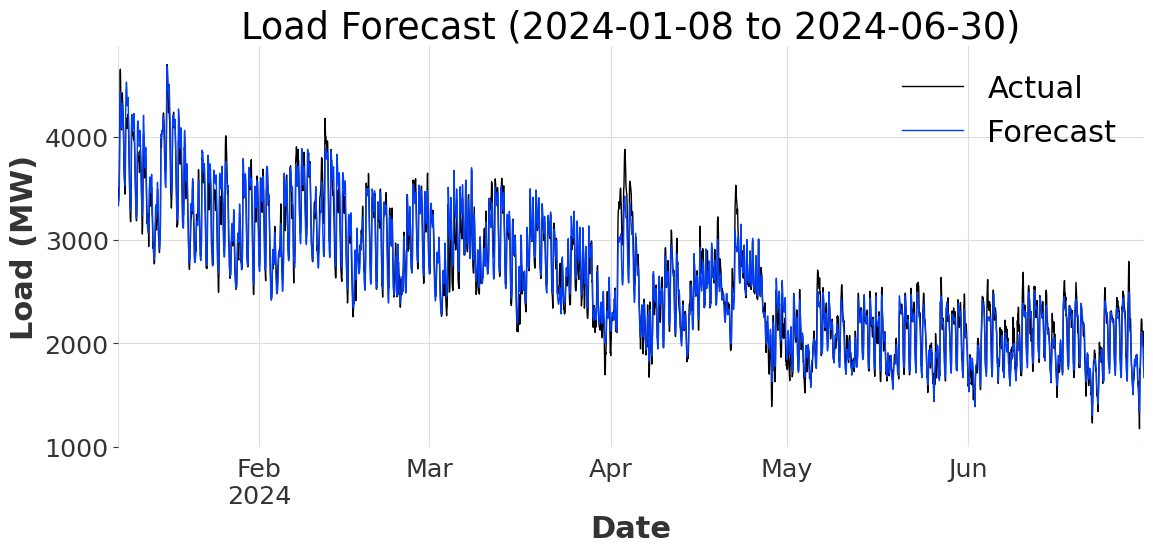

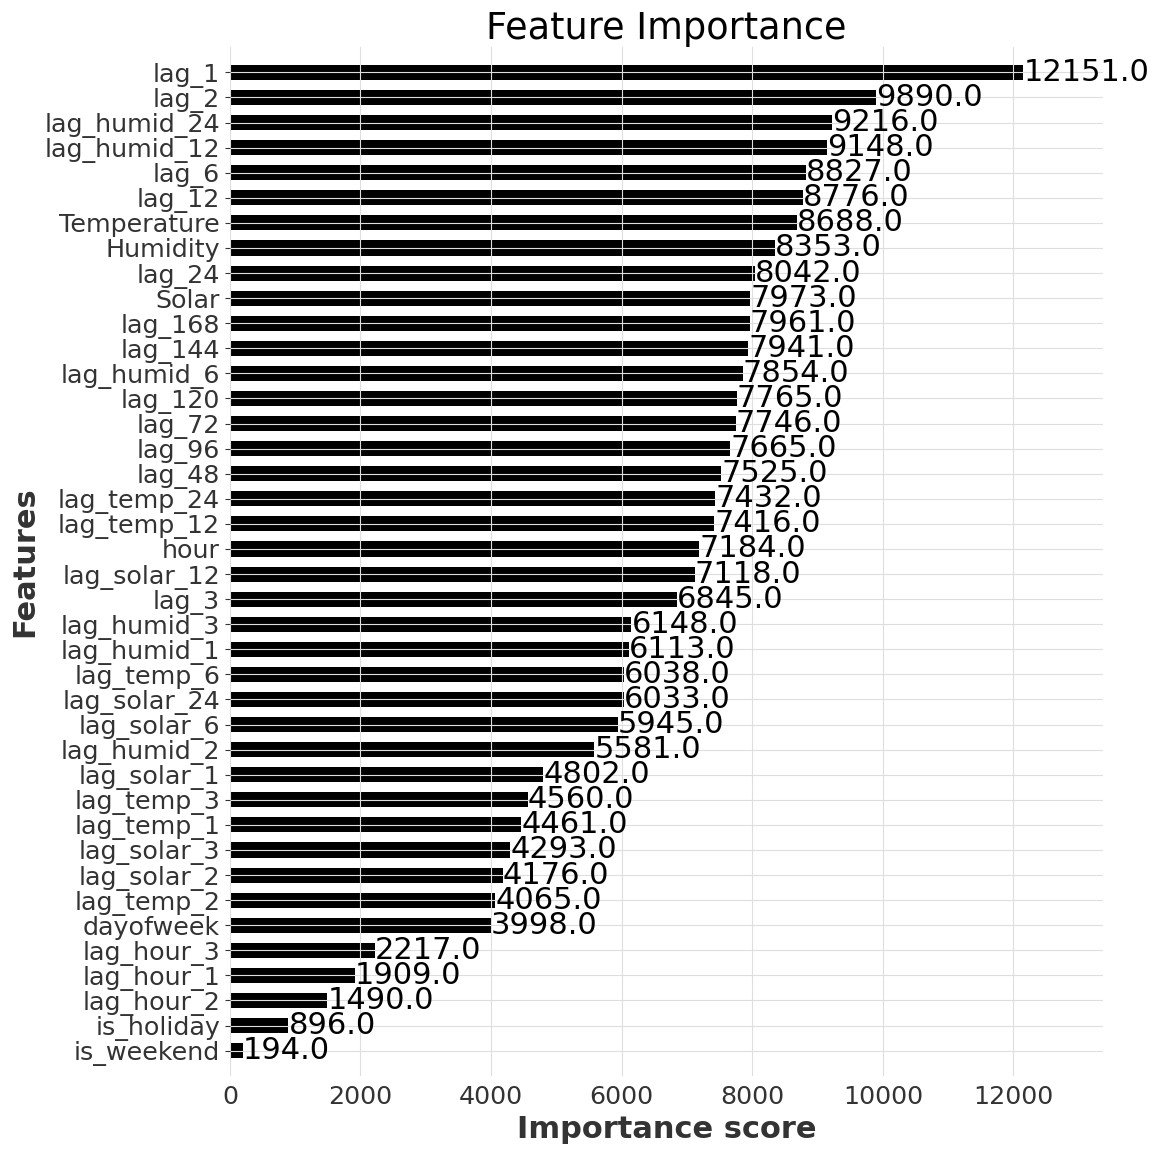

: 

: 

: 

: 

In [ ]:
plot_forecast(y_val_pred.loc[final_val_predictions.index],final_val_predictions, best_model, "XGB.pdf", True)

The most important features seem to be load lags close to the predicted time step. Furthermore, current and recent humidity and tempreature play an important role. This was consistent over many different model evaluations. Similarly, date features proved to be the least important consistently.

Now the final test set prediction can be run. The results (even if using the same model loaded from the pickle file) might vary across different code iterations, as different random noise is added to the weather data every time. The observed differences were not very significant, though. At most, MAPE changed for 0.05% and RMSE for ~5-6MW. 

MAPE: 5.06%
RMSE: 166.45
MAE: 123.11MW
Maximum MAPE: 15.76% on 2024-11-02
Minimum MAPE: 1.51% on 2024-12-10


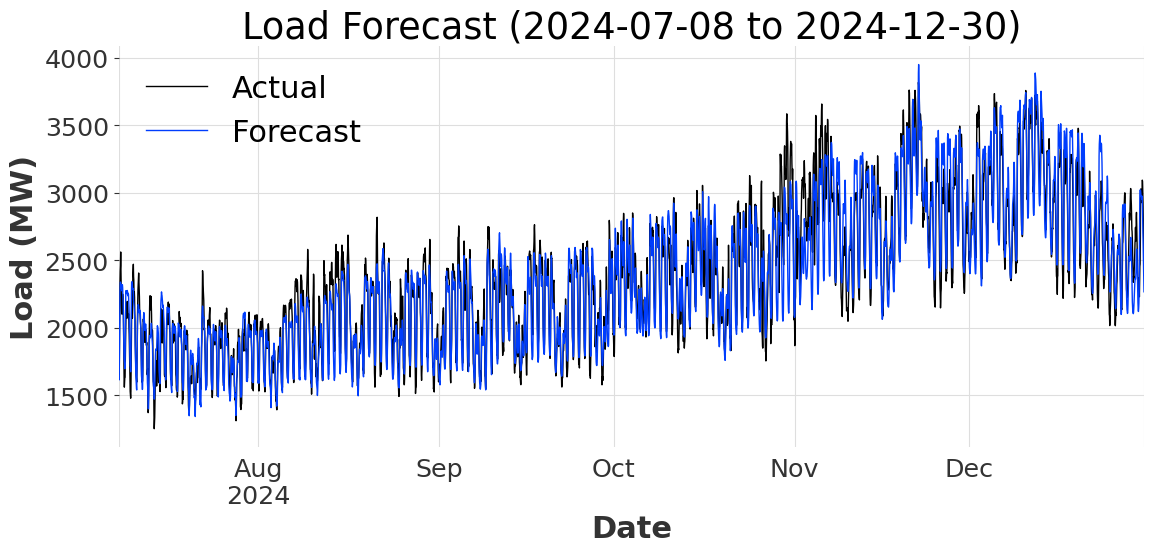

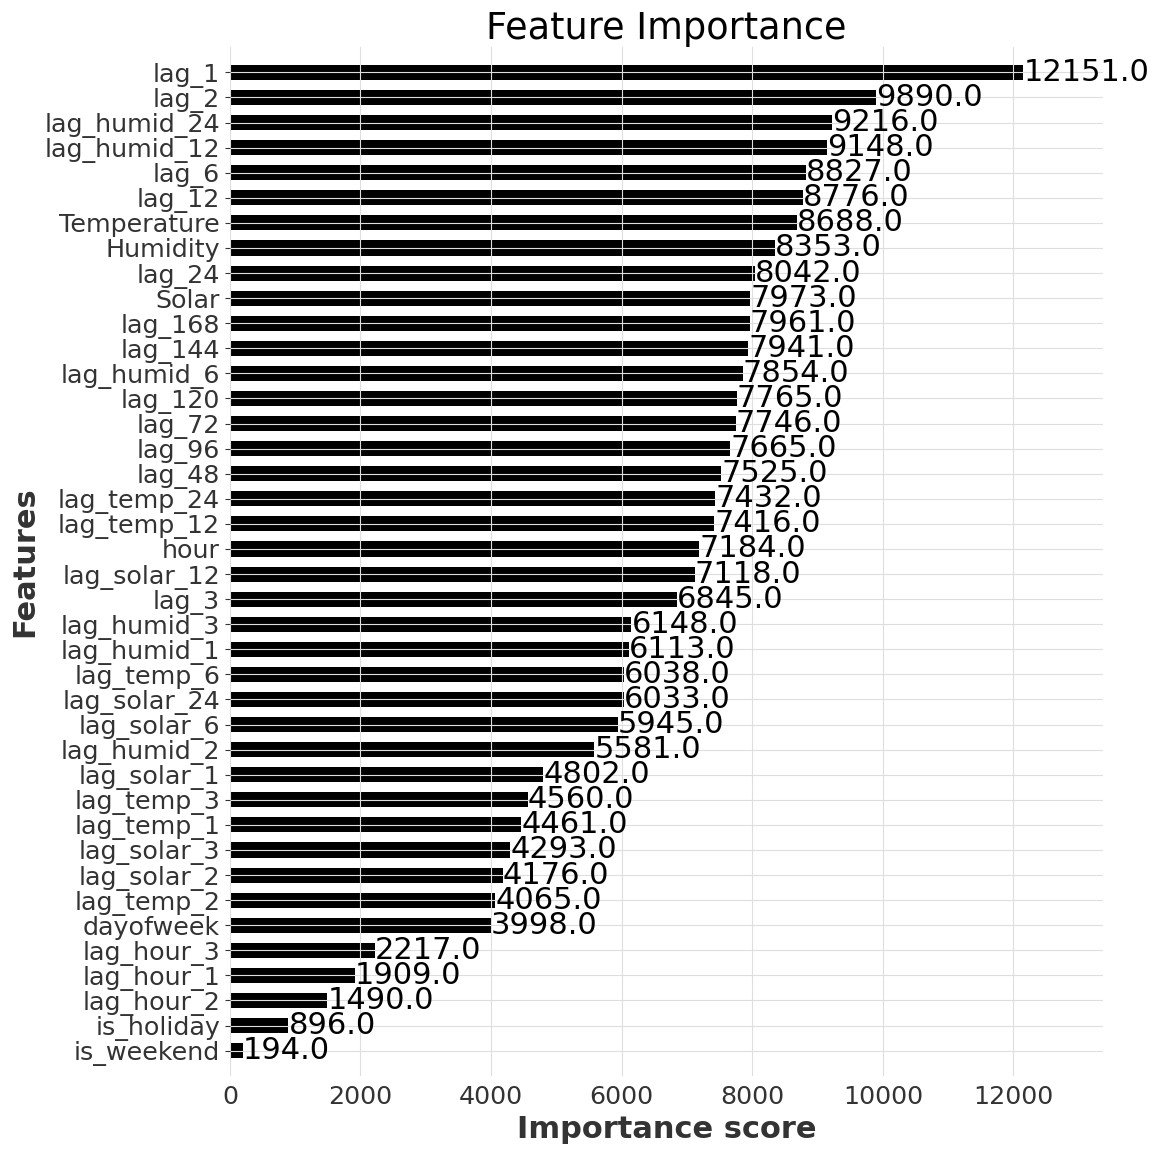

: 

: 

: 

: 

In [ ]:
final_test_predictions = predict_XGB(best_model,X_test_pred,y_test_init,y_test_known, y_test_pred)
print_evaluation_metrics(y_test_pred.loc[final_test_predictions.index],final_test_predictions)
plot_forecast(y_test_pred.loc[final_test_predictions.index],final_test_predictions, best_model, xgb_feat=True)

Finally, this section evaluates the model for ranges used in teh final report. As the model was designed such that it does day-forecasts on the previous day at 12:00 pm, the previously made forecast for the entire test set range already included day-forecasts. Therefore, the evaluation ranges were simply taken from the test set evalution and separately plotted below.

In [ ]:
eval_ranges = [
    ("2024-07-08", "2024-12-31"),
    ("2024-07-22", "2024-07-29"),
    ("2024-10-14", "2024-10-21"),
    ("2024-10-28", "2024-11-04"),
    ("2024-12-02", "2024-12-09"),
    ("2024-12-23", "2024-12-30"),
]
for start_date, end_date in eval_ranges:
    y_pred = y_test_pred[(y_test_pred.index>=start_date)&(y_test_pred.index<end_date)]
    print_evaluation_metrics(y_pred,final_test_predictions.loc[y_pred.index])
    plot_forecast(y_pred,final_test_predictions.loc[y_pred.index], best_model)
    

KeyboardInterrupt: 

: 

: 

: 

: 